In [1]:
from fastai.vision import *
from fastai.distributed import *
from fastai.metrics import error_rate
from fastai.callbacks import SaveModelCallback

if torch.cuda.is_available():
  print("Great! Good to go!")
else:
  print('CUDA is not up!')

Great! Good to go!


In [2]:
from gepcore.utils import cell_graph
from gepnet.model_v2 import get_gepnet, arch_config
from gepnet.utils import count_parameters
torch.backends.cudnn.benchmark = True

In [3]:
from pygraphviz import AGraph
import glob

In [4]:
graph = [AGraph(g) for g in glob.glob('comp_graphs/experiment_6/best/indv_0/*.dot')]
_, comp_graph = cell_graph.generate_comp_graph(graph)

In [5]:
import random
seed = 100
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# enable torch backends
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
#torch.backends.deterministic = True

In [12]:
conf = arch_config(comp_graph=comp_graph,
                   depth_coeff=1.0,
                   width_coeff=1.0,
                   channels=40,
                   repeat_list=[3, 4, 2],
                   classes=10)

net = get_gepnet(conf)
count_parameters(net)

3.62949

In [13]:
path = untar_data(URLs.CIFAR)
tfms = get_transforms(xtra_tfms=[cutout()]) 
bs = 128
data = (ImageList.from_folder(path/'train')
        .split_by_rand_pct(valid_pct=0.1, seed=seed) 
        .label_from_folder()
        .transform(tfms, size=32)
        .databunch(bs=bs, num_workers=num_cpus())
        .normalize(cifar_stats))

In [14]:
learn = Learner(data, net, metrics=[error_rate, accuracy], 
        model_dir='/home/cliff/ResearchProjects/models/evolution_search/').mixup()
learn.to_fp16()   

Learner(data=ImageDataBunch;

Train: LabelList (45000 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
automobile,automobile,automobile,automobile,automobile
Path: /home/cliff/.fastai/data/cifar10/train;

Valid: LabelList (5000 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
automobile,airplane,horse,automobile,airplane
Path: /home/cliff/.fastai/data/cifar10/train;

Test: None, model=GepNet(
  (stem): Sequential(
    (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (blocks): Sequential(
    (0): GepBlock(
      (relu): ReLU(inplace=True)
      (path_0): GepNetLayer(
        (conv1x1_0): Sequential(
          (0): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


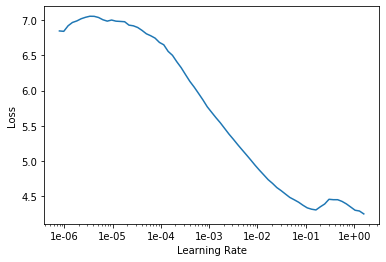

In [15]:
learn.lr_find(wd=4e-4,end_lr=100)

learn.recorder.plot()

In [ ]:
cb = SaveModelCallback(learn, every='improvement', monitor='accuracy', name='experiment_6_model_0')
learn.fit_one_cycle(1000, 3e-3, wd=0.0004, callbacks=[cb]) 

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.320730,2.259780,0.802400,0.197600,01:43
1,2.212017,2.050283,0.736800,0.263200,01:44
2,2.152700,1.934309,0.679600,0.320400,01:45
3,2.116961,1.901983,0.670800,0.329200,01:44
4,2.077038,1.842904,0.643200,0.356800,01:45
5,2.053813,1.804019,0.635600,0.364400,01:45
6,2.019666,1.839880,0.652800,0.347200,01:45


Better model found at epoch 0 with accuracy value: 0.19760000705718994.
Better model found at epoch 1 with accuracy value: 0.2632000148296356.
Better model found at epoch 2 with accuracy value: 0.3203999996185303.
Better model found at epoch 3 with accuracy value: 0.32919999957084656.
Better model found at epoch 4 with accuracy value: 0.35679998993873596.
Better model found at epoch 5 with accuracy value: 0.3643999993801117.


In [ ]:
############# Testing #############

In [ ]:
graph = [AGraph(g) for g in glob.glob('comp_graphs/experiment_1/best/indv_0/*.dot')]
_, comp_graph = cell_graph.generate_comp_graph(graph)

In [ ]:
conf = arch_config(comp_graph=comp_graph,
                   depth_coeff=1.0,
                   width_coeff=1.0,
                   channels=40,
                   repeat_list=[6, 6, 6, 6],
                   classes=10)

net = get_gepnet(conf)
count_parameters(net)

In [ ]:
tfms = get_transforms(do_flip=False)
path = untar_data(URLs.CIFAR)
bs = 256

data = (ImageList.from_folder(path)
        .split_by_folder(train='train', valid='test')
        .label_from_folder()
        .transform(tfms, size=32)
        .databunch(bs=bs, num_workers=num_cpus())
        .normalize(cifar_stats))

In [ ]:
model = Learner(data, net, metrics=[accuracy, error_rate]).load('experiment_1_model_1')
#model

In [ ]:
model.validate()

In [ ]:
preds,y,losses = model.get_preds(ds_type=DatasetType.Valid, with_loss=True)
preds[:5]